# Tutorial: Optimal Transport (OT) within the context of Hadron Collider Noise Mitigation

Author: Nathan Suri\
Date: 8/15/24

In [118]:
import os 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import horovod.tensorflow.keras as hvd
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import argparse
import h5py as h5
import utils
import matplotlib.pyplot as plt
import ABCNet
# from ABCNet import ABCNet, SWD
import subprocess
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve

hvd.init()

## Step 1: Understanding the Context

Before we dive into the application of optimal transport, we must first understand the data we will be working with and its corresponding and contained noise. The dataset that we will be using in this tutorial comes from the following study, PileUp Mitigation with Machine Learning (PUMML) (https://arxiv.org/abs/1707.08600). For more information about the data beyond that covered in this tutorial, feel free to check out: https://zenodo.org/records/2652034.

In [23]:
# Events with different number of pileup interactions (mu)
events_by_mu = h5.File('/global/cfs/cdirs/ntrain1/ot_tutorial/PUMMLEventsByMu_mH500.h5', 'r')

# Events with a different mass (mH) of the scaler resonance
events_by_mh = h5.File('/global/cfs/cdirs/ntrain1/ot_tutorial/PUMMLEventsBymH_Mu140.h5', 'r')

In [34]:
events_by_mu.keys()

<KeysViewHDF5 ['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', 

In [35]:
events_by_mh.keys()

<KeysViewHDF5 ['200', '2000', '300', '500', '700', '900']>

In [36]:
events_by_mu['140']

<HDF5 dataset "140": shape (2000, 715, 9), type "<f4">

In [37]:
events_by_mu.attrs['col_names']

array([b'pt', b'eta', b'phi', b'charged', b'vertex', b'puppi_weight',
       b'sk_weight', b'truth_jet', b'reco_jet'], dtype='|S12')

- pt - Transverse momentum of the particle, in GeV
- eta - Pseudorapidity of the particle, in GeV
- phi - Azimuthal angle of the particle (be careful about phi being periodic!)
- charged - 0 for neutral particles and 1 for charged particles
- vertex - Vertex id for the particle, 0 is the leading vertex and > 0 is pileup
- puppi_weight - PUPPI weight for the particle, using the parameters described in the PUMML paper
- sk_weight - SoftKiller weight for the particle, using the parameters described in the PUMML paper
- truth_jet - 0 if particle is in the hardest truth (found without pileup) LV jet, 1 if in second hardest LV jet (some events may not have a second hardest LV jet due to not passing kinematic cuts), and -1 if particle is not in an LV jet
- reco_jet - 0 if particle is in reco (found with pileup) jet corresponding to hardest LV jet, 1 if in reco jet corresponding to second hardest LV jet, and -1 if particle is not in any reco jet (rare)

### Particle Multiplicity

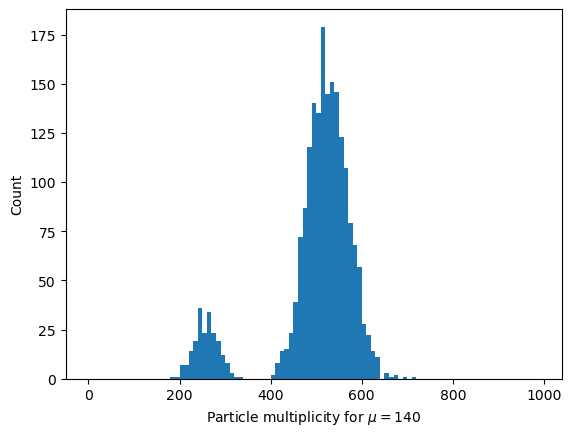

In [50]:
events_mu_140 = events_by_mu['140']
events_mu_140_ndarray = events_mu_140[()]
# Demonstrating the non-zero padded multiplicity of the events
plt.hist([np.count_nonzero(event[:,0] > 0) for event in events_mu_140_ndarray], bins=np.arange(0, 1000, 10))
plt.xlabel('Particle multiplicity for $\mu=140$')
plt.ylabel('Count')
plt.show()

Question: Why do you think we see this distribution shape?

### Weight Distribution

To compare with our OT methodology TOTAL, we have two competitive rule-based approaches: 1) PUPPI, the leading approach at the Compact Muon Solenoid (CMS) experiment at the Large Hadron Collider (LHC) and 2) SoftKiller (SK), the leading approach at the A Toroidal LHC Apparatus (ATLAS) experiment. Note the differences in outputs between the two algorithms.

In [117]:
puppi_weights = []
sk_weights = []
vertex_ids = []
pt_arr = []
for mu in range(140, 145):
    vertex_ids.append(np.ravel(events_by_mu[str(mu)][()][:,:,4]))
    puppi_weights.append(np.ravel(events_by_mu[str(mu)][()][:,:,5]))
    sk_weights.append(np.ravel(events_by_mu[str(mu)][()][:,:,6]))
    pt_arr.append(np.ravel(events_by_mu[str(mu)][()][:,:,0]))

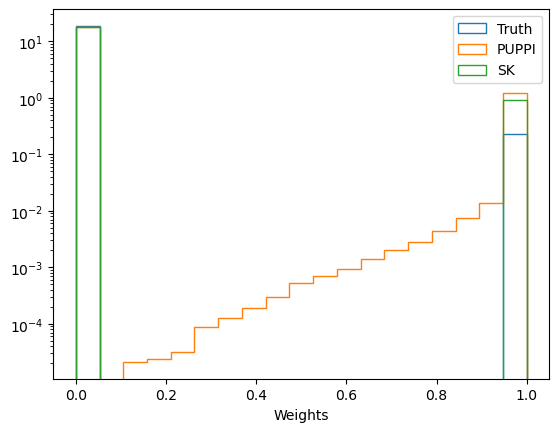

In [80]:
binning = np.linspace(0,1,20)
# Fix vertex_ids to be only primary vertex searching
plt.hist(np.hstack(vertex_ids), bins=binning, histtype='step', density=True, label='Truth')
plt.hist(np.hstack(puppi_weights), bins=binning, histtype='step', density=True, label='PUPPI')
plt.hist(np.hstack(sk_weights), bins=binning, histtype='step', density=True, label='SK')

plt.yscale('log')
plt.legend()
plt.xlabel('Weights')
plt.show()

While looking at the weights directly gives some insight into what the pileup subtraction algorithms do, we can view the efficiency of these algorithms better through Receiver Operating Characteristic (ROC) curves, which compare the true positive rate against the false positive rate of the algorithms in recovering the primary vertex ID.

In [124]:
auc = {}
fpr = {}
tpr = {}

# Each event is zero-padded so we reweight the predicted scores to account for this
pt_mod = [1e-10 if x==0 else x for x in np.hstack(pt_arr)]

auc['puppi'] = roc_auc_score((np.hstack(vertex_ids)==0).astype(int), np.hstack(puppi_weights), sample_weight=pt_mod)
fpr['puppi'],tpr['puppi'],_ = roc_curve((np.hstack(vertex_ids)==0).astype(int), np.hstack(puppi_weights), sample_weight=pt_mod)
auc['sk'] = roc_auc_score((np.hstack(vertex_ids)==0).astype(int), np.hstack(sk_weights), sample_weight=pt_mod)
fpr['sk'],tpr['sk'],_ = roc_curve((np.hstack(vertex_ids)==0).astype(int), np.hstack(sk_weights), sample_weight=pt_mod)

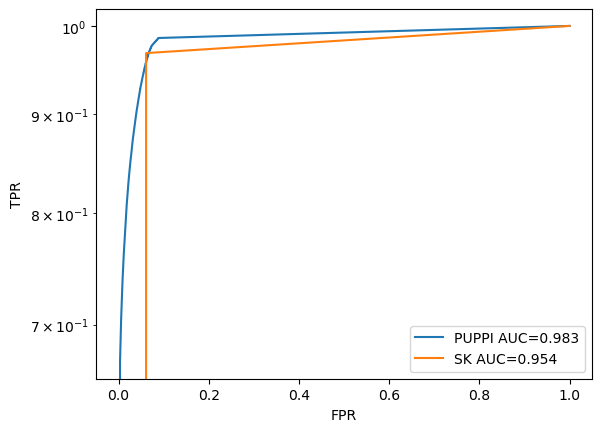

In [127]:
plt.plot(fpr['puppi'], tpr['puppi'],label='PUPPI'+" AUC="+str(np.round(auc['puppi'],3)))
plt.plot(fpr['sk'], tpr['sk'],label='SK'+" AUC="+str(np.round(auc['sk'],3)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.yscale('log')
plt.legend()

Question: Why do you think the SK ROC curve looks like this?

## Step 2: Data Manipulation

Now that we have studied in some detail the data we will be working with, we can begin to train our OT-based model to compare with PUPPI and SK.

In [2]:
# Loading datasets and applying a simple preprocessing
config_file = 'config_dev.json' # Store some training info
dataset_config = utils.LoadJson(config_file)
NSWD = dataset_config['NSWD'] # SWD is calculated considering only NSWD features
NPART=dataset_config['NPART'] # Maximum number of particles considered

In [100]:
import importlib
importlib.reload(utils)
# Without the loss of generality, we choose a mu value representative of LHC Run 2 conditions
test_mu = 30
data,label,_,_ = utils.preprocessing(os.path.join('/global/cfs/cdirs/ntrain1/ot_tutorial',dataset_config['FILES']),test_mu,nparts=NPART)
frac = 0.8 # Fraction of events used for training
data_size = data.shape[0]
data_label = data[:,:,:NSWD].copy() # Data with pileup used in the loss function to compare with label; the data without pileup
dataset = tf.data.Dataset.from_tensor_slices((data,np.concatenate([data_label,label[:,:,:NSWD]],-1)))
train_data, test_data = utils.split_data(dataset,data_size,frac)
del dataset, data, label, data_label

## Step 3: Model Training

With the data manipulation completed, we will move into the training of the model in proper. Run the following cell and while it is executing, we will study the actual use of OT in the loss calculation of our model by looking at the ABCNet.py script in the current directory.

In [115]:
BATCH_SIZE = dataset_config['BATCH']
LR = float(dataset_config['LR'])
NUM_EPOCHS = dataset_config['MAXEPOCH']
EARLY_STOP = dataset_config['EARLYSTOP']
checkpoint_folder = 'checkpoints_{}/checkpoint_test'.format(dataset_config['CHECKPOINT_NAME'])

In [119]:
import importlib
importlib.reload(ABCNet)
inputs,outputs = ABCNet.ABCNet(npoint=NPART,nfeat=dataset_config['SHAPE'][2])
model = Model(inputs=inputs,outputs=outputs)
opt = keras.optimizers.Adam(learning_rate=LR)
opt = hvd.DistributedOptimizer(
    opt, average_aggregated_gradients=True)
model.compile(loss=ABCNet.SWD,
              optimizer=opt,experimental_run_tf_function=False)
    
callbacks = [
    hvd.callbacks.BroadcastGlobalVariablesCallback(0),
    hvd.callbacks.MetricAverageCallback(),            
    ReduceLROnPlateau(patience=10, 
                      min_lr=1e-8,verbose=hvd.rank()==0),
    EarlyStopping(patience=EARLY_STOP,restore_best_weights=True),
    ]

if hvd.rank()==0:
    checkpoint = ModelCheckpoint(checkpoint_folder,save_best_only=True,mode='auto',
                                 period=1,save_weights_only=True)
        
    callbacks.append(checkpoint)
    print(model.summary())
    
load=False

if load:
    model.load_weights(checkpoint_folder)
else:
    history = model.fit(
        train_data.batch(BATCH_SIZE),
        epochs=NUM_EPOCHS,
        steps_per_epoch=int(data_size*frac/BATCH_SIZE),
        # steps_per_epoch=1,
        validation_data=test_data.batch(BATCH_SIZE),
        validation_steps=int(data_size*(1-frac)/BATCH_SIZE),
        verbose=1 if hvd.rank()==0 else 0,
        callbacks=callbacks
    )

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1000, 6)]    0           []                               
                                                                                                  
 tf.__operators__.getitem_27 (S  (None, 1000, 3)     0           ['input_5[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_28 (S  (None, 1000, 2)     0           ['tf.__operators__.getitem_27[0][
 licingOpLambda)                                                 0]']                             
                                                                                            

## Step 4: Results

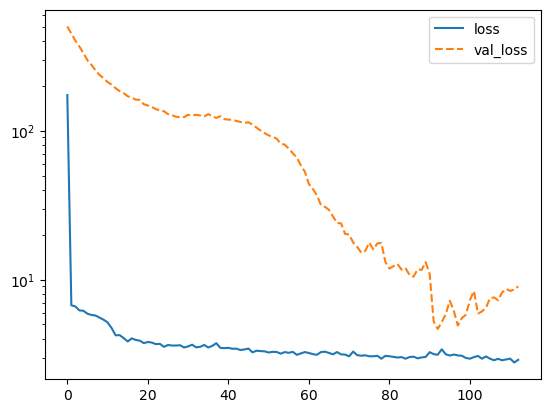

In [120]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', linestyle='dashed')
plt.yscale('log')
plt.legend()
plt.show()

Question: How would you interpret the loss curves? / Is this overtraining?

With our model now trained, we can now remake the plots from Step 1 to compare TOTAL to PUPPI and SK.

In [121]:
import importlib
importlib.reload(utils)
data,nopu,jet_info,vertex_truth = utils.preprocessing(os.path.join('/global/cfs/cdirs/ntrain1/ot_tutorial',dataset_config['FILES']),30,nparts=NPART)

total_w_test = model.predict(data,batch_size=200)
puppi_w_test = np.expand_dims(data[:,:,4],-1)
sk_w_test = np.expand_dims(data[:,:,5],-1)

data = utils.convert_preprocessing(data) # Undo data preprocessing to calculate jet resolution
nopu = utils.convert_preprocessing(nopu)

pt_test = np.expand_dims(data[:,:,2],-1)

10/10 [==============================] - 2s 144ms/step


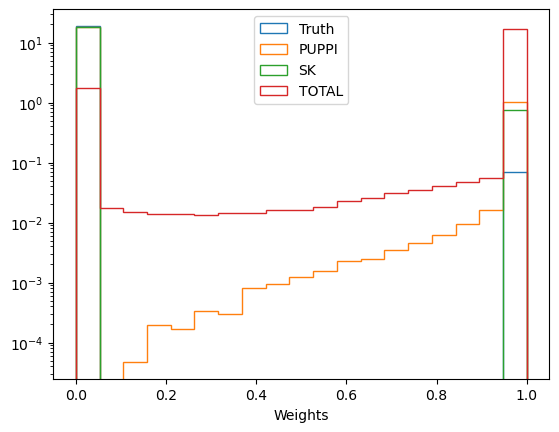

In [122]:
binning = np.linspace(0,1,20)
plt.hist(np.ravel(vertex_truth), bins=binning, histtype='step', density=True, label='Truth')
plt.hist(np.ravel(puppi_w_test), bins=binning, histtype='step', density=True, label='PUPPI')
plt.hist(np.ravel(sk_w_test), bins=binning, histtype='step', density=True, label='SK')
plt.hist(np.ravel(total_w_test), bins=binning, histtype='step', density=True, label='TOTAL')

plt.yscale('log')
plt.legend()
plt.xlabel('Weights')
plt.show()

In [123]:
# Each event is zero-padded so we can reweight the predicted scores to account for this
pt_mod_test = [1e-10 if x==0 else x for x in np.ravel(pt_test)]
auc_test = {}
fpr_test = {}
tpr_test = {}

auc_test['total'] = roc_auc_score((np.ravel(vertex_truth)==0).astype(int), np.ravel(total_w_test))
fpr_test['total'],tpr_test['total'],_ = roc_curve((np.ravel(vertex_truth)==0).astype(int), np.ravel(total_w_test))

auc_test['puppi'] = roc_auc_score((np.ravel(vertex_truth)==0).astype(int), np.ravel(puppi_w_test), sample_weight=pt_mod_test)
fpr_test['puppi'],tpr_test['puppi'],_ = roc_curve((np.ravel(vertex_truth)==0).astype(int), np.ravel(puppi_w_test), sample_weight=pt_mod_test)

auc_test['sk'] = roc_auc_score((np.ravel(vertex_truth)==0).astype(int), np.ravel(sk_w_test), sample_weight=pt_mod_test)
fpr_test['sk'],tpr_test['sk'],_ = roc_curve((np.ravel(vertex_truth)==0).astype(int), np.ravel(sk_w_test), sample_weight=pt_mod_test)

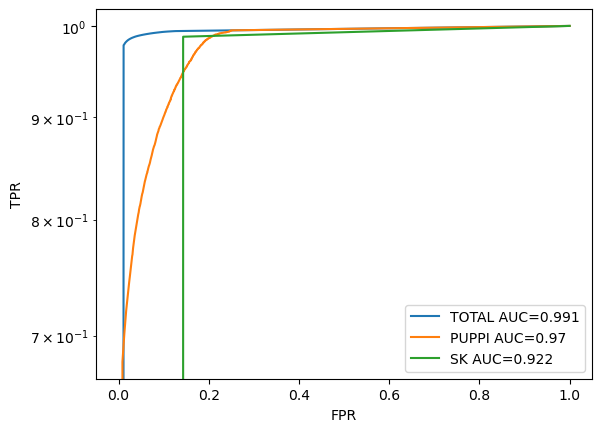

In [124]:
plt.plot(fpr_test['total'], tpr_test['total'],label='TOTAL'+" AUC="+str(np.round(auc_test['total'],3)))
plt.plot(fpr_test['puppi'], tpr_test['puppi'],label='PUPPI'+" AUC="+str(np.round(auc_test['puppi'],3)))
plt.plot(fpr_test['sk'], tpr_test['sk'],label='SK'+" AUC="+str(np.round(auc_test['sk'],3)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.yscale('log')
plt.legend()

### Jet $p_T$ Resolution

Just as with the weights, the ROC curves provide an incomplete picture as to the true efficacy of these algorithms. In the real world, the efficiency in recovering the true weights is secondary to the accurate reconstruction of important physical observables. One such observable is the $p_T$ resolution of jet objects. Jets are cones of particles produced by the hadronization of quarks and gluons. Since quarks and gluons are not directly observable, we infer their existence from jets, which is why having accurate measurements free of pileup impact is crucial.

(array([ 29.,  41.,  55.,  77.,  74.,  83.,  88., 112., 118., 120., 158.,
        174., 183., 169., 145., 109.,  92.,  54.,  31.]),
 array([100., 110., 120., 130., 140., 150., 160., 170., 180., 190., 200.,
        210., 220., 230., 240., 250., 260., 270., 280., 290.]),
 <BarContainer object of 19 artists>)

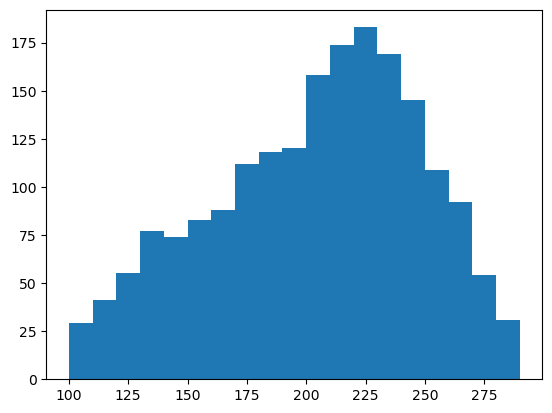

In [125]:
#Look only at the leading jet for simplicity
mask_jet1 = jet_info==0
px,py,pz=utils.convert_coordinate(nopu[:,:,:4],mask_jet1)

jet_pt_truth = np.sum(np.sqrt(px**2+py**2),1)[:,0]
plt.hist(jet_pt_truth,bins=np.arange(100, 300, 10))

In [126]:
px,py,pz=utils.convert_coordinate(data[:,:,:4],mask_jet1)
jet_pt_total = np.sum(np.sqrt(px**2+py**2)*(total_w_test),1)[:,0]
jet_pt_puppi = np.sum(np.sqrt(px**2+py**2)*(puppi_w_test),1)[:,0]
jet_pt_sk = np.sum(np.sqrt(px**2+py**2)*(sk_w_test),1)[:,0]

res_total = 100*(jet_pt_truth-jet_pt_total)/jet_pt_truth
res_puppi = 100*(jet_pt_truth-jet_pt_puppi)/jet_pt_truth
res_sk = 100*(jet_pt_truth-jet_pt_sk)/jet_pt_truth

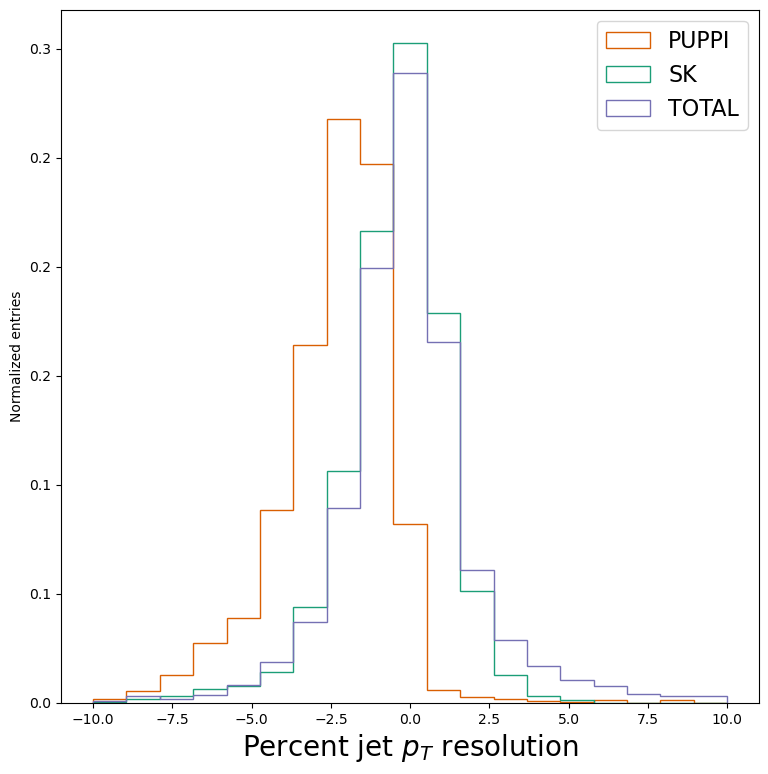

In [127]:
import importlib
importlib.reload(utils)
binning = np.linspace(-10,10,20)
# binning = np.linspace(-100,10,20)

label_names = {
        'puppi': 'PUPPI',
        'sk': 'SK',
        'abc': 'TOTAL',
        # 'reco': 'Data'
}
feed_dict = {
        'puppi': res_puppi,
        'sk': res_sk,
        'abc': res_total,
        # 'reco': res_reco,
}

fig,ax0 = utils.HistRoutine(feed_dict,xlabel=r'Percent jet $p_T$ resolution',
                            ylabel= 'Normalized entries',plot_ratio=False,binning=binning,
                            label_names=label_names)

If you are curious to see how far any of these algorithms has positively affected the resolution calculation, take a look at the comparison with the original calculation on the data before any pileup subtraction is done.

Note: In comparing SK and PUPPI, we should note the bias evident in the results by PUPPI manifest in a negative percent jet $p_T$ resolution. PUPPI, albeit also a rule-based approach, is more complex than SK and requires extensive tuning. Thus, we see another positive to using TOTAL that being a recovery of an unbiased resolution without any additional tuning.

Question: How could we tune the PUPPI results to be more unbiased using our setup?

## Step 5: $\mu$ Dependency Exercise

In [128]:
jetpT_res = {}
jetpT_res['total'] = []
jetpT_res['puppi'] = []
jetpT_res['sk'] = []
mu_arr = []

### 
# Try coding a loop structure to save the average jet pT resolution for a wide selection of mu values.
# We will plot these values in the next cell as a metric for model performance.
###

for mu in range(0, 170, 10):
    mu_arr.append(mu)
    
    data,nopu,jet_info,vertex_truth = utils.preprocessing(os.path.join('/global/cfs/cdirs/ntrain1/ot_tutorial',dataset_config['FILES']),mu,nparts=NPART)
    total_w_test = model.predict(data,batch_size=200)
    puppi_w_test = np.expand_dims(data[:,:,4],-1)
    sk_w_test = np.expand_dims(data[:,:,5],-1)
    
    data = utils.convert_preprocessing(data) # Undo data preprocessing to calculate jet resolution
    nopu = utils.convert_preprocessing(nopu)
    
    mask_jet1 = jet_info==0
    px,py,pz=utils.convert_coordinate(nopu[:,:,:4],mask_jet1)
    jet_pt_truth = np.sum(np.sqrt(px**2+py**2),1)[:,0]
    
    px,py,pz=utils.convert_coordinate(data[:,:,:4],mask_jet1)
    jet_pt_total = np.sum(np.sqrt(px**2+py**2)*(total_w_test),1)[:,0]
    jet_pt_puppi = np.sum(np.sqrt(px**2+py**2)*(puppi_w_test),1)[:,0]
    jet_pt_sk = np.sum(np.sqrt(px**2+py**2)*(sk_w_test),1)[:,0]

    res_total = 100*(jet_pt_truth-jet_pt_total)/jet_pt_truth
    res_puppi = 100*(jet_pt_truth-jet_pt_puppi)/jet_pt_truth
    res_sk = 100*(jet_pt_truth-jet_pt_sk)/jet_pt_truth

    jetpT_res['total'].append(res_total)
    jetpT_res['puppi'].append(res_puppi)
    jetpT_res['sk'].append(res_sk)

10/10 [==============================] - 1s 144ms/step


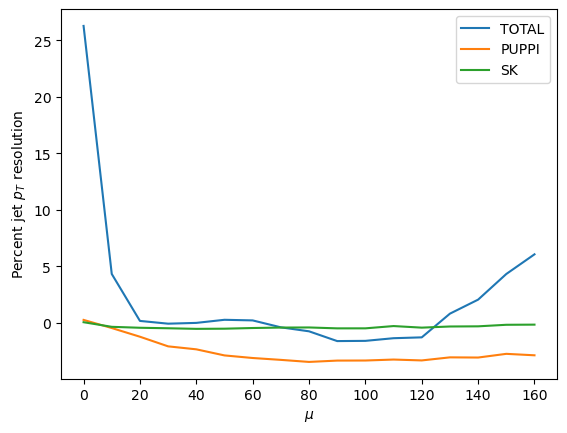

In [129]:
plt.plot(mu_arr, np.mean(jetpT_res['total'],axis=1), label='TOTAL')
plt.plot(mu_arr, np.mean(jetpT_res['puppi'],axis=1), label='PUPPI')
plt.plot(mu_arr, np.mean(jetpT_res['sk'],axis=1), label='SK')
plt.xlabel(r'$\mu$')
plt.ylabel(r'Percent jet $p_T$ resolution')
plt.legend()
plt.show()

Question: Why is the mean of the percent jet $p_T$ resolution not a perfect metric to evaluate model performance?

## Step 6: Further Studies

Now that you understand the basic structure of TOTAL, try playing around with some of the model's (hyper)parameters to improve the performance. To get you started, I have listed out a few potential avenues to pursue:

- Determine the impact of shifting the training mu value or even expanding the training set to multiple mu values
- Test the importance of the key model parameters such as the number of projections on the model results
- Check if any additional features used in the training could boost the model performance
- See what happens when the output layer is changed from hard_sigmoid to sigmoid

Other extensions:
- Quantify the accuracy of reconstructing resolutions by calculating their IQR
- Change the training dataset from the one which sets $\mu$ to the one that sets the mass of the scalar